In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla

np.set_printoptions(linewidth=130)

In [2]:
from fsmfuncs import *
from ibmfuncs import *
from gridfuncs import *

Numerical grid for the fluid

In [3]:
s1 = stretching(192, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)[0]
s2 = stretching(96, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)[0]
x = np.concatenate([-s2[::-1], s1[1:]])

s = stretching(128, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)[0]
y = np.concatenate([-s[::-1], s[1:]])

n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[1:-1], xp
v = np.zeros( (n-1, m) )

Immersed boundary

In [4]:
r_ = 0.5
l = int((2*np.pi*r_)/dxmin)
ang_ = 2*np.pi*np.arange(l)/l
xi = 0 + r_*np.cos(ang_)
eta = 0 + r_*np.sin(ang_)
ds = 2*np.pi*r_/l*np.ones(l)
uB = np.zeros_like(xi)
vB = np.zeros_like(xi)

Plot grid and immersed boundary

(-1, 1)

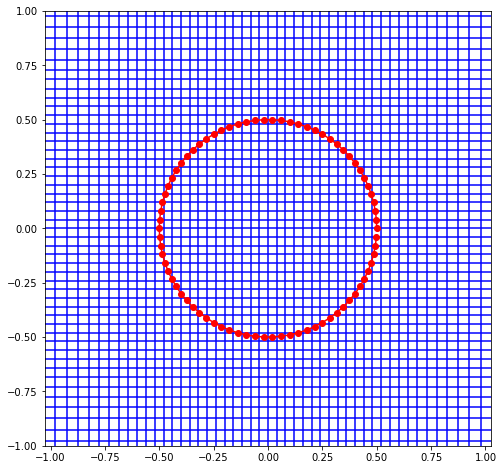

In [5]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-')
plt.plot(X.T, Y.T, 'b-')
plt.plot(xi, eta, 'ro-')
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)

In [6]:
uS, uN = np.ones(m-1), np.ones(m-1)
uE, uW = np.ones(n), np.ones(n)

vS, vN = np.zeros(m), np.zeros(m)
vE, vW = np.zeros(n-1), np.zeros(n-1)

u[:,:]=1
v[:,:]=0

Build matrices (I)

In [7]:
G, DuW, DuE, DvS, DvN = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dxp, dyp)
Lh, Lux0, Lux1, Luy0, Luy1, Lvx0, Lvx1, Lvy0, Lvy1 = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

Build matrices (II)

In [8]:
iRe = 1/40.0
dt = 0.30 * min(dxmin**2/iRe, dxmin)
print(dt, dxmin**2/iRe, dxmin)

0.012 0.064 0.04


In [9]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [10]:
q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q),  uS, uN, uW, uE, vS, vN, vW, vE)
Nu, Nv = Num1, Nvm1

In [11]:
nt = int(50/dt)
print("Performing", nt, "steps")

residuals = np.zeros(nt)
CFx = np.zeros(nt)
CFy = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE) + Luy0.dot(uS) + Luy1.dot(uN)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE) + Lvy0.dot(vS) + Lvy1.dot(vN)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 = - (DuW.dot(uW*dy) + DuE.dot(uE*dy) + DvS.dot(vS*dx) + DvN.dot(vN*dx))
    r2 = np.concatenate([-bc2, uB, vB])

    λ = iQTBNQ(Q.T.dot(qast) - r2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    
    f = -iEH(EET.dot(λ[n*m:]))
    CFx[k], CFy[k] = -2*np.sum(f[:l]*ds), -2*np.sum(f[l:]*ds)
        
    if k%100==0:
        print(k, k*dt, residuals[k], CFx[k], CFy[k])
    
    q = qp1
    uE = uE - dt/dx[-1]*(uE - iR.dot(q)[:n*(m-1)].reshape((n, m-1))[:,-1])
    
    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uS, uN, uW, uE, vS, vN, vW, vE)

Performing 4166 steps
0 0.0 2.13039417831 299.948108734 0.000439851474291
100 1.2 0.0110243718482 2.06655514745 -8.56008443611e-05
200 2.4 0.00774674896083 1.93821497841 -0.000200638155117
300 3.6 0.00586293010871 1.84446493942 -0.000286240471153
400 4.8 0.00467289735182 1.78053610424 -0.000302961877226
500 6.0 0.00384102977533 1.73604594413 -0.000263446314519
600 7.2 0.00321653744667 1.70396871353 -0.00020724537709
700 8.4 0.00274560534282 1.68014198979 -0.000172710403277
800 9.6 0.00239068124538 1.66206766335 -0.000174866296643
900 10.8 0.00211945038051 1.64819822594 -0.000201543716784
1000 12.0 0.00190841185952 1.63752151954 -0.00022707813691
1100 13.2 0.0017412388573 1.62924455363 -0.000231893960972
1200 14.4 0.00160614641265 1.62253610841 -0.000214514080672
1300 15.6 0.00149392991993 1.61671180255 -0.000189615420868
1400 16.8 0.0013977326275 1.61164571597 -0.000175448817108
1500 18.0 0.00131362820046 1.60735445259 -0.000180520088929
1600 19.2 0.0012396679217 1.60368862863 -0.00019

In [12]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n-1, m))
p = λ[:n*m].reshape((n,m))
f = λ[n*m:]

Display solution

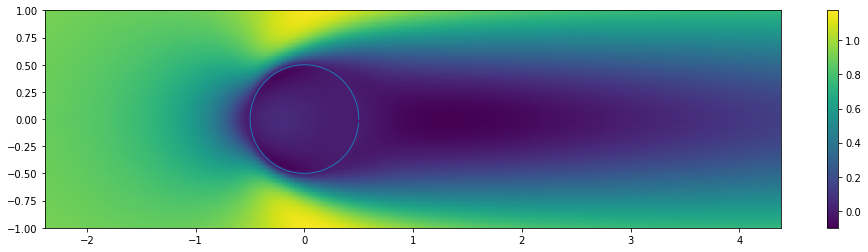

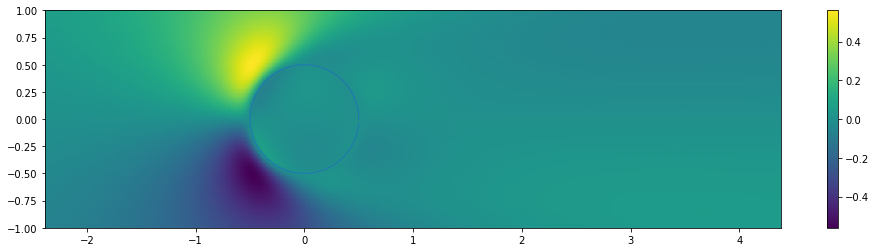

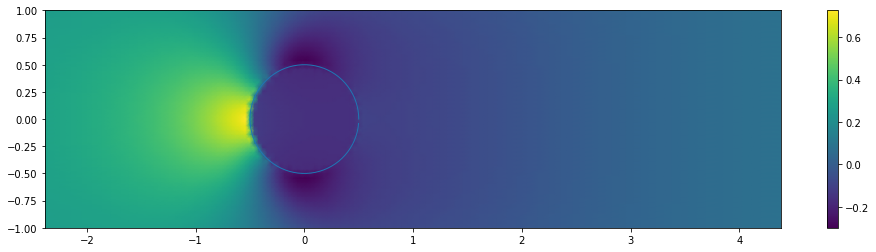

In [13]:
x0, x1 = -1, 3
y0, y1 = -1, 1
plt.figure(figsize=(5.5*3,4))
#plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.figure(figsize=(5.5*3,4))
#plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

plt.figure(figsize=(5.5*3,4))
#plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.plot(xi, eta, lw=1)
plt.axis('equal')
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.colorbar()

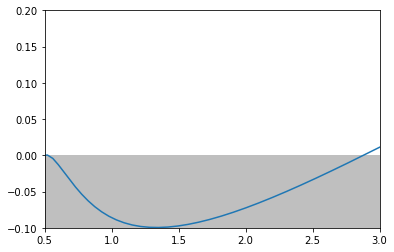

In [14]:
plt.plot(xu, u[n//2,:])
plt.xlim(0.5, 3)
plt.ylim(-0.1, 0.2)
plt.axhspan(-0.1, 0, facecolor='0.5', alpha=0.5)

Text(0,0.5,'$C_d$')

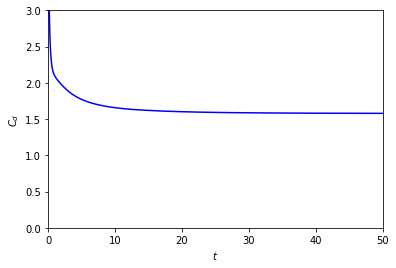

In [16]:
plt.plot(np.arange(len(CFx))*dt, CFx, 'b-')
plt.xlim(0, 50)
plt.ylim(0, 3)
plt.xlabel(r'$t$')
plt.ylabel(r'$C_d$')